# Sacramento Kings Intern Project - 6/26/17 - Calvin Floyd

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.lines as mlines
%matplotlib inline
from math import*
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
from scipy import stats
import datetime
from math import isnan

In [2]:
complete_data = pd.read_csv('complete_data.csv')
complete_data = complete_data.sort_values(by=['season','game','quarter','shot_game_clock'],
                                          ascending=[True,True,True,False])
complete_data = complete_data.reset_index(drop=True)

data_dictionary = pd.read_csv('data_dictionary.csv')

players = pd.read_csv('players.csv')
full_name = []
for i in range(players.shape[0]):
    full_name.append(players['firstname'][i]+' '+players['lastname'][i])
players['full_name'] = full_name

teams = pd.read_csv('teams.csv')

In [3]:
for i in range(data_dictionary.shape[0]):
    
    print(str(data_dictionary['id'][i])+' --> '+str(data_dictionary['shot id'][i])+'\n')

season --> year in which the regular season ends (i.e., 2014 for the 2013-14 season)

game --> game ID of the form (year month day home_team_id)

quarter --> quarter of the game

team --> shooter's team

opponent --> shooter's opponent's team

home --> indicator with a 1 if the shooter is playing at home

offense_basket --> indicates whether the shooter is shooting at the basket on the left or right side of the court

passer --> player_id of the player who passed the ball to the shooter

pass_x --> x coordinate of the passer location

pass_y --> y coordinate of the passer location

pass_distance --> length of the pass to the shooter

recorded_assist --> whether or not an assist was recorded

pass_shot_clock --> value of the shot clock when the ball was passed, counting backwards in seconds from 24

pass_game_clock --> value of the game clock when the ball was passed, counting backwards in minutes from 720 at the top of the quarter to 0 at the bottom

shooter --> player_id of the player

# Dimensions of NBA Basketball Court

- 50 feet wide (0 to 50 on y-axis)
- 94 feet long (0 to 94 on x-axis)
- NBA 3-point arc is 23 feet 9 inches away from the basket (23.75 feet)
    - from x = [14,29] feet and x = [65,80] feet 
- NBA corner three is 22 feet away from the basket
    - extends from x = [0,14] feet and x = [80,94] feet
- Center of left basket
    - (5.25,25) feet
- Center of right basket 
    - (88.75,25) feet
- Paint
    - y = [17,33] feet
    - x = [0,19], [75,94] feet  
- Restricted Area
    - y = [22,28] feet
    - x = [4,9.25], [84.75,90] feet

# Court Functions used to illustrate the basketball court

In [5]:
ob_area = 5
def NBACourt(wood_color='#F5DEB3',out_of_bounds='0.25',line_color='white',ob_area=ob_area):

    rectangle1 = plt.Rectangle((0,0),94,50,fc=wood_color,ec='none',zorder=1)
    plt.gca().add_patch(rectangle1)
    
    rectangle2 = plt.Rectangle((-ob_area,-ob_area),94+2*ob_area,50+2*ob_area,fc=out_of_bounds,ec='none',zorder=0)
    plt.gca().add_patch(rectangle2)
    
    # NBA 3-point arc
    plt.plot([0,14],[3,3],color=line_color,linewidth=2)
    plt.plot([80,94],[3,3],color=line_color,linewidth=2)
    plt.plot([0,14],[47,47],color=line_color,linewidth=2)
    plt.plot([80,94],[47,47],color=line_color,linewidth=2)
    
    y1 = np.linspace(3,47,100)
    x1 = np.sqrt(23.75**2-(y1-25)**2)+5.25
    plt.plot(x1,y1,color=line_color,linewidth=2)
    
    y2 = y1
    x2 = -np.sqrt(23.75**2-(y2-25)**2)+88.75
    plt.plot(x2,y2,color=line_color,linewidth=2)
    
    # Halfcourt line
    plt.plot([47,47],[0,50],color=line_color,linewidth=2)
    
    # Out-of-bounds lines
    plt.plot([0,94],[0,0],color=line_color,linewidth=2)
    plt.plot([0,94],[50,50],color=line_color,linewidth=2)
    plt.plot([0,0],[0,50],color=line_color,linewidth=2)
    plt.plot([94,94],[0,50],color=line_color,linewidth=2)
    
    # Painted Area
    plt.plot([0,19],[17,17],color=line_color,linewidth=2)
    plt.plot([0,19],[33,33],color=line_color,linewidth=2)
    plt.plot([19,19],[17,33],color=line_color,linewidth=2)
    plt.plot([75,94],[17,17],color=line_color,linewidth=2)
    plt.plot([75,94],[33,33],color=line_color,linewidth=2)
    plt.plot([75,75],[17,33],color=line_color,linewidth=2)
    
    # Baskets
    circle1 = plt.Circle((5.25,25),18/12,edgecolor='orange',fill=False,zorder=2,linewidth=3)
    plt.gca().add_patch(circle1)
    plt.plot([4-.5,4-.5],[22,28],color='orange',linewidth=3)
    circle2 = plt.Circle((88.75,25),18/12,edgecolor='orange',fill=False,zorder=2,linewidth=3)
    plt.gca().add_patch(circle2)
    plt.plot([90+.5,90+.5],[22,28],color='orange',linewidth=3)

    # Restricted Areas
    y3 = np.linspace(21,29,100)
    x3 = np.sqrt(4**2-(y3-25)**2)+5.25
    plt.plot(x3,y3,color=line_color,linewidth=2)
    
    y4 = y3
    x4 = -np.sqrt(4**2-(y4-25)**2)+88.75
    plt.plot(x4,y4,color=line_color,linewidth=2)
    
def RegionLines(line_color='0.5',diff=.25):

    # Center MidRange
    plt.plot([19+diff,37],[33+diff,33+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([19+diff,37],[17-diff,17-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([57,75-diff],[33+diff,33+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([57,75-diff],[17-diff,17-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([19+diff,19+diff],[17-diff,33+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([75-diff,75-diff],[17-diff,33+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([37,37],[0,50],color=line_color,ls='--',linewidth=1)
    plt.plot([57,57],[0,50],color=line_color,ls='--',linewidth=1)
    
    # NBA 3-point arc
    plt.plot([0,14],[3-diff,3-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([80,94],[3-diff,3-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([0,14],[47+diff,47+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([80,94],[47+diff,47+diff],color=line_color,ls='--',linewidth=1)
    
    y1 = np.linspace(3,47,100)
    x1 = np.sqrt((23.75+diff)**2-(y1-25)**2)+5.25
    plt.plot(x1,y1,color=line_color,ls='--',linewidth=1)
    
    y2 = y1
    x2 = -np.sqrt((23.75+diff)**2-(y2-25)**2)+88.75
    plt.plot(x2,y2,color=line_color,ls='--',linewidth=1)
    
    # Painted Area
    plt.plot([0,19+diff],[17-diff,17-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([0,19+diff],[33+diff,33+diff],color=line_color,ls='--',linewidth=1)
    plt.plot([75-diff,94],[17-diff,17-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([75-diff,94],[33+diff,33+diff],color=line_color,ls='--',linewidth=1)
    
    # Restricted Areas
    y3 = np.linspace(21,29,100)
    x3 = np.sqrt((4)**2-(y3-25)**2)+5.25
    plt.plot(x3,y3,color=line_color,ls='--',linewidth=1)
    
    y4 = y3
    x4 = -np.sqrt((4)**2-(y4-25)**2)+88.75
    plt.plot(x4,y4,color=line_color,ls='--',linewidth=1)
    
    plt.plot([4,5.25],[29,29],color=line_color,ls='--',linewidth=1)
    plt.plot([4,5.25],[21,21],color=line_color,ls='--',linewidth=1)
    plt.plot([88.75,90],[29,29],color=line_color,ls='--',linewidth=1)
    plt.plot([88.75,90],[21,21],color=line_color,ls='--',linewidth=1)
    
    # Sideline Separation
    plt.plot([14,14],[33+diff,50],color=line_color,ls='--',linewidth=1)
    plt.plot([14,14],[0,17-diff],color=line_color,ls='--',linewidth=1)
    plt.plot([80,80],[33+diff,50],color=line_color,ls='--',linewidth=1)
    plt.plot([80,80],[0,17-diff],color=line_color,ls='--',linewidth=1)
    
    
def RegionNumbers(txt_color='w',txt_alpha=1.0,txt_size=10):
    
    # Region 1 - Restricted Area
    plt.text((9.25+6.5)/2,(17+33)/2,'1',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((94-9.25+94-6.5)/2,(17+33)/2,'1',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 2 - Painted Area
    plt.text((9.25+19)/2,(17+33)/2,'2',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((94-9.25+75)/2,(17+33)/2,'2',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 3 - Right Sideline Mid-Range
    plt.text(7,(47+33)/2,'3',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+94)/2,(3+17)/2,'3',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')

    # Region 4 - Right Mid-Range
    plt.text((14+26)/2,(33+45)/2,'4',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+68)/2,(5+17)/2,'4',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 5 - Center Mid-Range
    plt.text((19+29)/2,(17+33)/2,'5',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((75+65)/2,(17+33)/2,'5',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 6 - Left Mid-Range
    plt.text((14+26)/2,(5+17)/2,'6',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+68)/2,(33+45)/2,'6',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 7 - Left Sideline Mid-Range
    plt.text(7,(3+17)/2,'7',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+94)/2,(33+47)/2,'7',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 8 - Right Corner Three
    plt.text(7,(47+50)/2,'8',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+94)/2,(3+0)/2,'8',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 9 - Right Wing Three
    plt.text((19+29)/2,(40+47)/2,'9',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((75+65)/2,(3+10)/2,'9',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 10 - Straight On Three
    plt.text((29+34)/2,(17+33)/2,'10',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((65+60)/2,(17+33)/2,'10',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 11 - Left Wing Three
    plt.text((19+29)/2,(3+10)/2,'11',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((75+65)/2,(40+47)/2,'11',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    
    # Region 12 - Left Corner Three
    plt.text(7,(3+0)/2,'12',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')
    plt.text((80+94)/2,(47+50)/2,'12',                     
             color=txt_color,weight='bold',size=txt_size,zorder=3,alpha=txt_alpha,
             horizontalalignment='center',verticalalignment='center')


# Region Numbers & Descriptions
1. Restricted Area
2. Other Painted Area
3. Right Sideline Mid-Range
4. Right Mid-Range
5. Center Mid-Range
6. Left Mid-Range
7. Left Sideline Mid-Range
8. Right Corner Three
9. Right Wing Three
10. Straight On Three
11. Left Wing Three
12. Left Corner Three

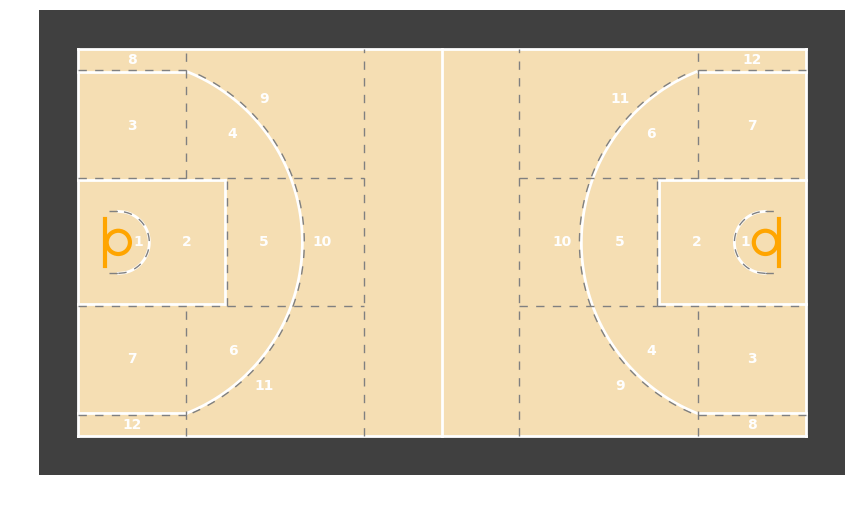

In [47]:
fig_dim = 10
fig0 = plt.figure(0,figsize=((94+2*ob_area)/fig_dim,(50+2*ob_area)/fig_dim))
NBACourt()
RegionLines()
RegionNumbers()
plt.xlim([-ob_area,94+ob_area])
plt.ylim([-ob_area,50+ob_area])
plt.grid('off')
plt.axis('off')
plt.show()

fig0.savefig('bballRegions.png',bbox_inches='tight')

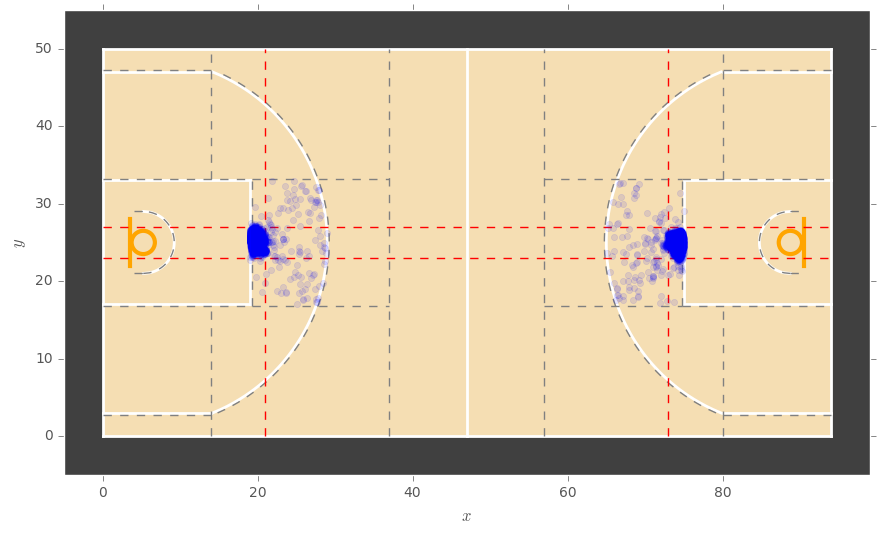

In [168]:
fig1_dim = 10
fig1 = plt.figure(1,figsize=((94+2*ob_area)/fig_dim,(50+2*ob_area)/fig_dim))
NBACourt()
RegionLines()
plt.xlim([-ob_area,94+ob_area])
plt.ylim([-ob_area,50+ob_area])
plt.grid('off')

df = c_data_edit
df = df[df['shot_shot_clock'] == 24.0]
df = df[df['shot_region'] == 5]
plt.scatter(df['shot_x'],df['shot_y'],color='blue',alpha=0.1,zorder=3)
plt.plot([21,21],[0,50],ls='--',color='red',linewidth=1)
plt.plot([73,73],[0,50],ls='--',color='red',linewidth=1)
plt.plot([0,94],[27,27],ls='--',color='red',linewidth=1)
plt.plot([0,94],[23,23],ls='--',color='red',linewidth=1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

# Functions to be used later on in the code

In [88]:
# function to be used to find which region a shot location falls in
def ShotInfo(basket,x,y):
        
    s_type = {1:'layup',2:'paint',3:'jumpshot',4:'jumpshot',5:'jumpshot',6:'jumpshot',
              7:'jumpshot',8:'jumpshot',9:'jumpshot',10:'jumpshot',11:'jumpshot',12:'jumpshot',
              13:'long_jumpshot'}
    
    pts = {1:2,2:2,3:2,4:2,5:2,6:2,7:2,8:3,9:3,10:3,11:3,12:3,13:3}
    
    if basket == 'L':
        
        if y >= 17 and y <= 33:
            
            if x < 19:
                
                if x < 4:
                    
                    region = 2
                
                elif np.sqrt((x-5.25)**2 + (y-25)**2) <= 4:
                    
                    region = 1
                    
                else:
                    
                    region = 2
                    
            elif np.sqrt((x-5.25)**2 + (y-25)**2) <= 23.75:
                
                region = 5
                
            elif x > 37:
                
                region = 13
                
            else:
                
                region = 10
                
        elif y < 17:
            
            if x <= 14:
                
                if y < 3:
                    
                    region = 12
                    
                else:
                    
                    region = 7
                    
            elif np.sqrt((x-5.25)**2 + (y-25)**2) <= 23.75:
                
                region = 6
                
            elif x > 37:
                
                region = 13
                
            else: 
                
                region = 11
                
        elif y > 33:
            
            if x <= 14:
                
                if y > 47:
                    
                    region = 8
                    
                else:
                    
                    region = 3
                    
            elif np.sqrt((x-5.25)**2 + (y-25)**2) <= 23.75:
                
                region = 4
                
            elif x > 37:
                
                region = 13
                
            else: 
                
                region = 9
    
    elif basket == 'R':
        
        if y >= 17 and y <= 33:
            
            if x > 75:
                
                if x > 90:
                    
                    region = 2
                
                elif np.sqrt((x-88.75)**2 + (y-25)**2) <= 4:
                    
                    region = 1
                    
                else:
                    
                    region = 2
                    
            elif np.sqrt((x-88.75)**2 + (y-25)**2) <= 23.75:
                
                region = 5
                
            elif x < 57:
                
                region = 13
                
            else:
                
                region = 10
                
        elif y < 17:
            
            if x >= 80:
                
                if y < 3:
                    
                    region = 8
                    
                else:
                    
                    region = 3
                    
            elif np.sqrt((x-88.75)**2 + (y-25)**2) <= 23.75:
                
                region = 4
                
            elif x < 57:
                
                region = 13
                
            else: 
                
                region = 9
                
        elif y > 33:
            
            if x >= 80:
                
                if y > 47:
                    
                    region = 12
                    
                else:
                    
                    region = 7
                    
            elif np.sqrt((x-88.75)**2 + (y-25)**2) <= 23.75:
                
                region = 6
                
            elif x < 57:
                
                region = 13
                
            else: 
                
                region = 11

    return [region,s_type[region],pts[region]]


def PlayerName(playerid):
    
    df = players[players['player_id'] == playerid]
    df = df.reset_index(drop=True)
    
    if df.shape[0] != 1:
        return 'NaN'
    else:
        return str(df['firstname'][0])+' '+str(df['lastname'][0])
   
def PlayerPos(playername):
    
    df = players[players['full_name'] == playername]
    df = df.reset_index(drop=True)
    
    if df.shape[0] != 1:
        return 'NaN'
    else:
        return df['position'][0]
    
def PlayerID(playername):
    
    df = players[players['full_name'] == playername]
    df = df.reset_index(drop=True)
    
    if df.shape[0] != 1:
        return 'NaN'
    else:
        return df['player_id'][0]
 
# function used to determine whether if something will be deemed a free throw or not
def ft_indicator(index,df):
    
    if df['recorded_assist'][index] == 1:
            
            return 0
        
    else:
            
        shot_x = df['shot_x'][index]
        shot_y = df['shot_y'][index]

        if shot_x <= 21 and shot_x >= 19: 

            if shot_y >= 23 and shot_y <= 27:

                return 1

            else: 

                return 0

        elif shot_x >= 73 and shot_x <= 75:

            if shot_y >= 23 and shot_y <= 27:

                return 1

            else:

                return 0
            
        else:

            return 0


In [23]:
c_data_edit = complete_data
shot_region_vec = np.empty(c_data_edit.shape[0])
shot_type_vec = []
pts_vec = np.empty(c_data_edit.shape[0])
shooter_name_vec = []
shooter_pos_vec = []
passer_name_vec = []

# print('Start : '+str(datetime.datetime.now().time()))
for i in range(c_data_edit.shape[0]):
    
    s_x = c_data_edit['shot_x'][i]
    s_y = c_data_edit['shot_y'][i]
    bskt = c_data_edit['offense_basket'][i]
    s_id = c_data_edit['shooter'][i]
    p_id = c_data_edit['passer'][i]
    s_info = ShotInfo(bskt,s_x,s_y)
    
    shooter_name_vec.append(PlayerName(s_id))
    shooter_pos_vec.append(PlayerPos(PlayerName(s_id)))
    passer_name_vec.append(PlayerName(p_id))
    shot_region_vec[i] = s_info[0]
    shot_type_vec.append(s_info[1])
    pts_vec[i] = s_info[2]
    
#     if i%10000 == 0:
#         print('Iteration '+str(i)+' : '+str(datetime.datetime.now().time()))
    
# print('End : '+str(datetime.datetime.now().time()))

c_data_edit['passer_name'] = passer_name_vec
c_data_edit['shooter_name'] = shooter_name_vec
c_data_edit['shooter_pos'] = shooter_pos_vec
c_data_edit['shot_region'] = shot_region_vec
c_data_edit['shot_type'] = shot_type_vec
c_data_edit['potential_pts'] = pts_vec

Start : 10:53:36.639376
Iteration 0 : 10:53:36.651912
Iteration 10000 : 10:54:22.512315
Iteration 20000 : 10:55:04.838471
Iteration 30000 : 10:55:47.412916
Iteration 40000 : 10:56:32.033384
Iteration 50000 : 10:57:14.588611
Iteration 60000 : 10:57:56.333655
Iteration 70000 : 10:58:38.178429
Iteration 80000 : 10:59:20.815921
Iteration 90000 : 11:00:03.077536
Iteration 100000 : 11:00:44.354812
Iteration 110000 : 11:01:29.565621
Iteration 120000 : 11:02:11.863729
Iteration 130000 : 11:02:53.559258
Iteration 140000 : 11:03:36.166495
Iteration 150000 : 11:04:18.566395
Iteration 160000 : 11:05:00.527707
Iteration 170000 : 11:05:42.876592
Iteration 180000 : 11:06:25.025661
Iteration 190000 : 11:07:08.875650
Iteration 200000 : 11:07:52.432361
Iteration 210000 : 11:08:47.367270
Iteration 220000 : 11:09:43.130233
Iteration 230000 : 11:10:29.271194
Iteration 240000 : 11:11:16.354825
Iteration 250000 : 11:12:02.821416
Iteration 260000 : 11:12:45.548234
Iteration 270000 : 11:13:29.439339
Iteration 

In [89]:
ft_vec = np.zeros(c_data_edit.shape[0])

# print('Start : '+str(datetime.datetime.now().time()))
for i in range(c_data_edit.shape[0]):
    
    ft_vec[i] = ft_indicator(i,df=c_data_edit)
    
#     if i%100000 == 0:
#         print('Iteration '+str(i)+' : '+str(datetime.datetime.now().time()))
    
# print('End : '+str(datetime.datetime.now().time()))

c_data_edit['free_throw'] = ft_vec

Start : 23:44:21.447414
Iteration 0 : 23:44:21.452484
Iteration 100000 : 23:44:28.583274
Iteration 200000 : 23:44:35.505700
Iteration 300000 : 23:44:42.330690
Iteration 400000 : 23:44:49.154428
End : 23:44:56.113424


# Creating dataframes which will store the field goal percentages of each player from each region

In [104]:
plyrs = c_data_edit['shooter_name'].unique()
df = c_data_edit[c_data_edit['free_throw'] == 0]
df = df[df['shot_region'] != 13]

fgpct_df_tot = {}
sweetspots_df_tot = {}
quality_regions = {}
num_swt_spts = 6
regions = [1,2,3,4,5,6,7,8,9,10,11,12]
pts = {1:2,2:2,3:2,4:2,5:2,6:2,7:2,8:3,9:3,10:3,11:3,12:3}

for plyr in plyrs:
    
    if plyr in players['full_name'].unique():

        fgpct_df_tot[plyr] = pd.DataFrame(index=regions,columns=['fg_pct','weighted_fg_pct',
                                                         'num_of_attempts','league_avg_fg_pct',
                                                         'above_league_avg'])
    sweetspots_df_tot[plyr] = []
    quality_regions[plyr] = []
    
for plyr in plyrs:
    
    if plyr in players['full_name'].unique():

        df_0 = df[df['shooter_name'] == plyr]

        for rgn in regions:

            df_1 = df_0[df_0['shot_region'] == rgn]

            if df_1.shape[0] == 0:

                fgpct_df_tot[plyr].loc[rgn,'fg_pct'] = 0.0
                fgpct_df_tot[plyr].loc[rgn,'num_of_attempts'] = 0

            else:

                fgpct_df_tot[plyr].loc[rgn,'fg_pct'] = sum(df_1['made'])/df_1.shape[0]
                fgpct_df_tot[plyr].loc[rgn,'weighted_fg_pct'] = pts[rgn]*(fgpct_df_tot[plyr].loc[rgn,'fg_pct'])
                fgpct_df_tot[plyr].loc[rgn,'num_of_attempts'] = df_1.shape[0]

        fgpct_df_tot[plyr] = fgpct_df_tot[plyr].sort_values(by='fg_pct',ascending=False)
        
        for i in np.arange(num_swt_spts):
        
            sweetspots_df_tot[plyr].append(fgpct_df_tot[plyr].head(num_swt_spts).index[i])
    
for plyr in plyrs:
    
    if plyr in players['full_name'].unique():

        df_0 = df[df['shooter_name'] != plyr]

        for rgn in regions:

            df_1 = df_0[df_0['shot_region'] == rgn]

            league_avg = sum(df_1['made'])/df_1.shape[0]
            fgpct_df_tot[plyr].loc[rgn,'league_avg_fg_pct'] = league_avg

            if league_avg < fgpct_df_tot[plyr].loc[rgn,'fg_pct']:

                fgpct_df_tot[plyr].loc[rgn,'above_league_avg'] = 1
                quality_regions[plyr].append(rgn)

            else:

                fgpct_df_tot[plyr].loc[rgn,'above_league_avg'] = 0

# Analyzing characteristics of assisted field goals

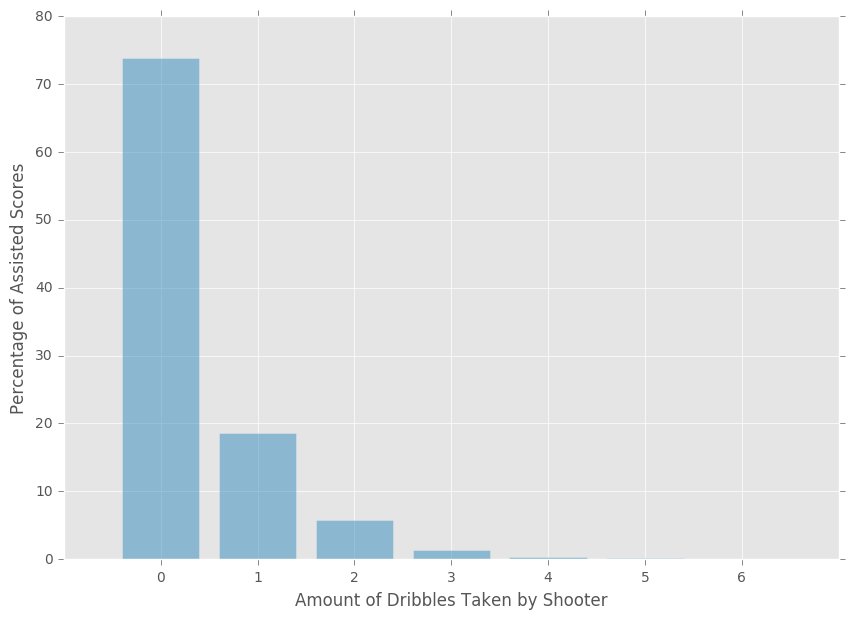

In [67]:
df = c_data_edit[c_data_edit['recorded_assist'] == 1]
df = df[df['free_throw'] == 0]
df = df[df['shot_region'] == 1]

num_dribbles = [0,1,2,3,4,5,6]
count = []

for n_d in num_dribbles:
    
    count.append(100*(df[df['dribbles'] == n_d].shape[0]/df.shape[0]))

fig3 = plt.figure(3,figsize=(10,7))
plt.bar(np.arange(len(count)),count,align='center',alpha=0.5)
plt.xticks(np.arange(len(count)),num_dribbles)
plt.ylabel('Percentage of Assisted Scores')
plt.xlabel('Amount of Dribbles Taken by Shooter')

plt.show()

fig3.savefig('dribbles.png',bbox_inches='tight')

# Calculating assists and quality set-ups per game

In [178]:
plyrs_shooters = c_data_edit['shooter_name'].unique()
plyrs = []

for plyr in plyrs_shooters:
    if plyr in players['full_name'].unique():
        plyrs.append(plyr)

df = c_data_edit[c_data_edit['free_throw'] == 0]
df = df[df['shot_region'] != 13]

setups_df = pd.DataFrame(index = plyrs,
                         columns=['tot_assists','APG','tot_pts_off_assists','POAPG',
                                  'tot_setups','SUPG','tot_setups_not_assists','SUNAPG',
                                  'tot_poten_pts_off_su','PPOSUPG','tot_pts_off_unassisted_su','POUASUPG'])

for plyr in plyrs:
    
    gms = set(list(df[df['shooter_name'] == plyr]['game'].unique())+
            list(df[df['passer_name'] == plyr]['game'].unique()))

    assists_vec = []
    setups_vec = []
    pts_off_assists_vec = []
    pts_off_su_vec = []
    unassisted_su_vec = []
    pts_unassisted_su_vec = []
    
    df_0 = df[df['passer_name'] == plyr]
    
    for gm in gms:
        
        df_1 = df_0[df_0['game'] == gm]
        df_2 = df_1[df_1['recorded_assist'] == 1]
        assists_vec.append(df_2.shape[0])
        pts_off_assists_vec.append(sum(df_2['potential_pts']))
        
        df_3 = df_1[df_1['dribbles'] <= 1]
        df_3 = df_3.reset_index(drop=True)
        
        if df_3.shape[0] == 0:
        
            setups_vec.append(0)
            pts_off_su_vec.append(0)
            unassisted_su_vec.append(0)
            pts_unassisted_su_vec.append(0)

        else:
            
            swtspot = np.zeros(df_3.shape[0])
            una = np.zeros(df_3.shape[0])

            for i in range(df_3.shape[0]):

                if df_3['shot_region'][i] in quality_regions[df_3['shooter_name'][i]]:

                    swtspot[i] = 1

                    if df_3['recorded_assist'][i] != 1:

                        una[i] = 1

            setups_vec.append(sum(swtspot))
            pts_off_su_vec.append(sum(df_3[swtspot == 1]['potential_pts']))
            unassisted_su_vec.append(sum(una))
            pts_unassisted_su_vec.append(sum(df_3[una == 1]['potential_pts']))

    setups_df.loc[plyr,'tot_assists'] = sum(assists_vec)
    setups_df.loc[plyr,'APG'] = np.mean(assists_vec)
    setups_df.loc[plyr,'tot_pts_off_assists'] = sum(pts_off_assists_vec)
    setups_df.loc[plyr,'POAPG'] = np.mean(pts_off_assists_vec)
    setups_df.loc[plyr,'tot_setups'] = sum(setups_vec)
    setups_df.loc[plyr,'QSUPG'] = np.mean(setups_vec)
    setups_df.loc[plyr,'tot_setups_not_assists'] = sum(unassisted_su_vec)
    setups_df.loc[plyr,'UQSUPG'] = np.mean(unassisted_su_vec)
    setups_df.loc[plyr,'APSUPG'] = np.mean(unassisted_su_vec)+np.mean(assists_vec)
    setups_df.loc[plyr,'tot_poten_pts_off_su'] = sum(pts_off_su_vec)
    setups_df.loc[plyr,'PPOQSUPG'] = np.mean(pts_off_su_vec)
    setups_df.loc[plyr,'tot_pts_off_unassisted_su'] = sum(pts_unassisted_su_vec)
    setups_df.loc[plyr,'PPOUQSUPG'] = np.mean(pts_unassisted_su_vec)
    setups_df.loc[plyr,'PPOSUPG'] = setups_df.loc[plyr,'POAPG'] + setups_df.loc[plyr,'PPOUQSUPG']

In [179]:
df = setups_df
df = df[['APG','QSUPG','UQSUPG','POAPG','PPOUQSUPG','PPOSUPG']]
df.sort_values(by='PPOSUPG',ascending=False).head(10)

,APG,QSUPG,UQSUPG,POAPG,PPOUQSUPG,PPOSUPG
Chris Paul,8.08824,11.882353,5.964706,18.1941,13.841176,32.0353
John Wall,7.35638,10.531915,5.393617,16.8245,12.728723,29.5532
Ricky Rubio,6.63846,7.800000,4.223077,14.7231,10.192308,24.9154
Ty Lawson,6.95122,6.682927,3.487805,16.0305,8.646341,24.6768
Stephen Curry,6.125,8.266304,4.288043,13.7935,10.266304,24.0598
Rajon Rondo,6.536,7.680000,4.000000,14.8,9.144000,23.944
Russell Westbrook,5.92199,8.262411,3.978723,13.2979,9.382979,22.6809
Jeff Teague,5.3743,7.832402,4.122905,12.2179,9.748603,21.9665
Deron Williams,5.03165,7.670886,4.221519,11.5316,9.981013,21.5127
LeBron James,5.27326,6.395349,3.081395,12.4535,8.029070,20.4826


# Calculating the amount of quality shots a player takes

In [109]:
plyrs_shooters = c_data_edit['shooter_name'].unique()
plyrs = []

for plyr in plyrs_shooters:
    if plyr in players['full_name'].unique():
        plyrs.append(plyr)

pts = {1:2,2:2,3:2,4:2,5:2,6:2,7:2,8:3,9:3,10:3,11:3,12:3}
        
df = c_data_edit[c_data_edit['free_throw'] == 0]
df = df[df['shot_region'] != 13]

quality_shots_df = pd.DataFrame(index = plyrs,columns=['position','tot_shots','SPG',
                                                       'tot_quality_shots','QSPG','QSPPG',
                                                       'tot_potential_quality_pts','qs_ratio'])

for plyr in plyrs:
    
    gms = set(list(df[df['shooter_name'] == plyr]['game'].unique())+
            list(df[df['passer_name'] == plyr]['game'].unique()))

    num_shots_vec = []
    num_qs_vec = []
    qs_pts_vec = []
    
    df_0 = df[df['shooter_name'] == plyr]
    
    for gm in gms:
        
        df_1 = df_0[df_0['game'] == gm]
        df_1 = df_1.reset_index(drop=True)
        num_shots_vec.append(df_1.shape[0])
                
        if df_1.shape[0] == 0:
        
            qs_pts_vec.append(0)
            num_qs_vec.append(0)

        else:

            swtspot = 0
            swtspot_pts = 0
            
            for i in range(df_1.shape[0]):

                if df_1['shot_region'][i] in quality_regions[plyr]:

                    swtspot += 1
                    swtspot_pts += pts[df_1['shot_region'][i]]

            num_qs_vec.append(swtspot)
            qs_pts_vec.append(swtspot_pts)

    quality_shots_df.loc[plyr,'position'] = PlayerPos(plyr)        
    quality_shots_df.loc[plyr,'tot_shots'] = sum(num_shots_vec)
    quality_shots_df.loc[plyr,'SPG'] = np.mean(num_shots_vec)
    quality_shots_df.loc[plyr,'tot_quality_shots'] = sum(num_qs_vec)
    quality_shots_df.loc[plyr,'QSPG'] = np.mean(num_qs_vec)
    quality_shots_df.loc[plyr,'tot_potential_quality_pts'] = sum(qs_pts_vec)
    quality_shots_df.loc[plyr,'QSPPG'] = np.mean(qs_pts_vec)
    
    if sum(num_shots_vec) == 0:
        
        quality_shots_df.loc[plyr,'qs_ratio'] = 0.0
        
    else:

        quality_shots_df.loc[plyr,'qs_ratio'] = sum(num_qs_vec)/sum(num_shots_vec)


In [175]:
df = quality_shots_df[quality_shots_df['tot_shots'] > 500]
df = df[['SPG','QSPG','QSPPG','qs_ratio']]
df.sort_values(by='QSPPG',ascending=False).head(10)

,SPG,QSPG,QSPPG,qs_ratio
Stephen Curry,14.0543,14.0543,34.5489,1
Kevin Durant,15.8955,14.8731,34.3507,0.935681
Klay Thompson,13.1154,13.1154,31.5769,1
Carmelo Anthony,16.2808,12.5822,27.6575,0.772823
Kyrie Irving,15.1818,10.8951,26.1049,0.717642
LaMarcus Aldridge,15.9763,12.8107,26.0651,0.801852
Blake Griffin,14.267,12.3409,24.9148,0.864994
Dirk Nowitzki,11.8973,11.1243,24.4703,0.93503
Al Jefferson,14.6013,11.9608,23.9608,0.819158
Chris Paul,11.4235,10.5706,23.2882,0.925335


# Calculating Quality Potential Points Per Game (QPPPG)

In [180]:
tot_qp_df = pd.DataFrame(index=plyrs,columns=['PPOSUPG','QSPPG','QPPPG'])

for plyr in plyrs:
    
        tot_qp_df.loc[plyr,'PPOSUPG'] = setups_df.loc[plyr,'PPOSUPG']
        tot_qp_df.loc[plyr,'QSPPG'] = quality_shots_df.loc[plyr,'QSPPG']
        tot_qp_df.loc[plyr,'QPPPG'] = setups_df.loc[plyr,'PPOSUPG']+quality_shots_df.loc[plyr,'QSPPG']

tot_qp_df.sort_values(by='QPPPG',ascending=False).head(10)

,PPOSUPG,QSPPG,QPPPG
Stephen Curry,24.0598,34.5489,58.6087
Chris Paul,32.0353,23.2882,55.3235
Kevin Durant,13.8507,34.3507,48.2015
John Wall,29.5532,18.2766,47.8298
Kyrie Irving,19.2448,26.1049,45.3497
LeBron James,20.4826,22.6802,43.1628
Damian Lillard,19.9053,20.3421,40.2474
Blake Griffin,14.358,24.9148,39.2727
Russell Westbrook,22.6809,16.3546,39.0355
Klay Thompson,7.08791,31.5769,38.6648


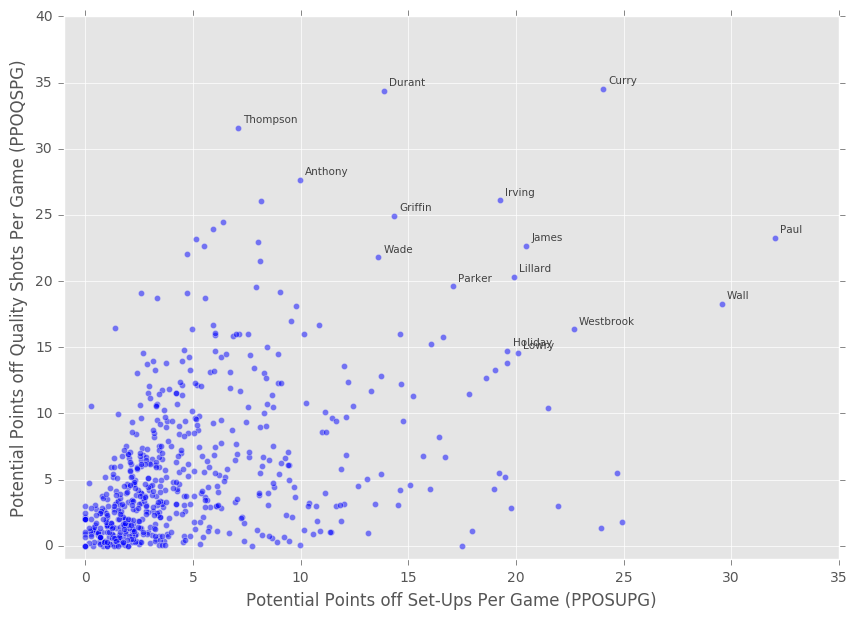

In [171]:
def PlayerLastName(playername):

    df = players[players['full_name'] == playername]
    df = df.reset_index(drop=True)
    
    return df['lastname'][0]

fig5 = plt.figure(5,figsize=(10,7))
plt.scatter(tot_qp_df['TPOASUPG'],tot_qp_df['QSPPG'],alpha=.5)

top = 15
df = tot_qp_df.sort_values(by='TQPPG',ascending=False).head(top)
for i in range(top):
    
    plt.text(df['TPOASUPG'][i]+.25,df['QSPPG'][i]+.25,PlayerLastName(df.index[i]),
             size=7.5,ha='left',va='bottom',color='0.25')
   
plt.xlim([-1,35])
plt.ylim([-1,40])
plt.xlabel('Potential Points off Set-Ups Per Game (PPOSUPG)')
plt.ylabel('Potential Points off Quality Shots Per Game (PPOQSPG)')
plt.show()